# Defining fuzzy logic system for evaluating TRS performance

<!-- ![load case](../images/TRS_example/load_case.png "Turbine rear structural thermal loads") -->

<p style="text-align:center;">
    <img src="../images/TRS_example/load_case.png" alt="load case" title="Turbine rear structural thermal loads" width="250px" align="center"/>
</p>

This example shows how to evaluate the design margins of a turbine rear structure (TRS) when experiencing thermal loads. Two temperatures affect the TRS' performance. They are the temperature of the nacelle compartment $T_1$ and the temperature of the gas surface $T_1$. The output that we are interested in is the safety factor $n_\textrm{safety}$.

Simulation results tell us that $n_\textrm{safety}$ decreases when the difference ${\lvert}T_2 - T_1{\rvert}$ and vice versa. Based on this qualitative knowledge, we can use ``dmLib`` to quantify these parameters and find out how much change can a TRS absorb.

## Define fuzzy parameters

First let us import all the required tools to define the parameters ``T1``, ``T2``, and ``n_safety`` as fuzzy parameters

In [2]:
from dmLib import triangularFunc, fuzzySet, fuzzyRule, fuzzySystem

Next we define the **universe** in which our parameters can vary. 
$$
250 \le T_1 \le 450 \\
480 \le T_2 \le 680 \\
1.0 \le n_\text{safety} \le 6.0 \\
$$

In [3]:
import numpy as np

# Generate universe variables
lb = np.array([250, 480, 1.0])
ub = np.array([450, 680, 6.0])
labels = ['T1','T2','n_safety']

universe = np.linspace(lb, ub, 100) # grid for all variables

Next, we define the **membership functions** in the form of a triangular function. The left foot of the triangle is given by ``shapes_lo``, the center of the triangle is given by ``shapes_md``, and the right foot of the triangle is given by ``shapes_hi``.

In [4]:
# Define shape of triangular membership functions
shapes_lo = np.array([lb,               lb,             lb + (ub-lb)/2  ])
shapes_md = np.array([lb + (ub-lb)/4,   lb + (ub-lb)/2, ub - (ub-lb)/4  ])
shapes_hi = np.array([lb + 1*(ub-lb)/2, ub,             ub              ])

Next we create fuzzy set object for each parameter by looping over ``lb``, ``ub``, and ``n_safety`` and visualize the results fuzzy sets.

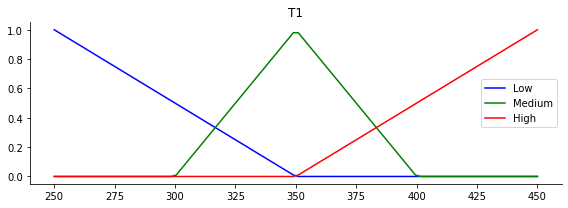

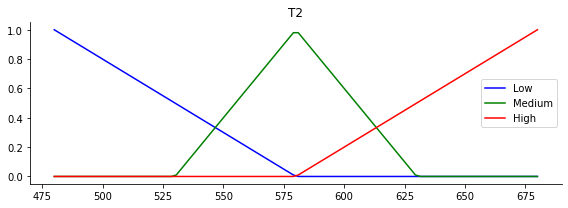

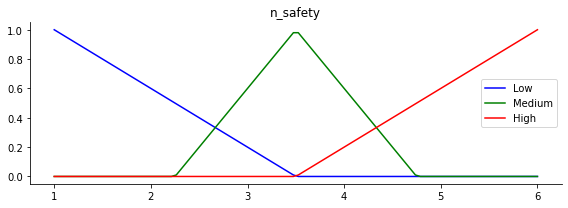

In [5]:
# Generate fuzzy membership functions
fuzzy_sets = []
for i in range(len(lb)):
    lo = triangularFunc(universe[:,i],labels[i])
    lo.setFunc(shapes_lo[0,i],shapes_lo[1,i],shapes_lo[2,i])

    md = triangularFunc(universe[:,i],labels[i])
    md.setFunc(shapes_md[0,i],shapes_md[1,i],shapes_md[2,i])

    hi = triangularFunc(universe[:,i],labels[i])
    hi.setFunc(shapes_hi[0,i],shapes_hi[1,i],shapes_hi[2,i])

    fuzzyset_i = fuzzySet(lo,md,hi,labels[i])

    fuzzy_sets += [fuzzyset_i]

# label each fuzzy set
temp_T1 = fuzzy_sets[0]
temp_T2 = fuzzy_sets[1]
n_safety = fuzzy_sets[2]

# Visualize these universes and membership functions
temp_T1.view()
temp_T2.view()
n_safety.view()

## Define fuzzy rules

Next we define the **fuzzy rules** needed to infer the value of ``n_safety``. The **antecedents** are ``T1`` and ``T2`` and the **consequent** is ``n_safety``.
The following fuzzy rules should be applied in our fuzzy logic system:

<table>
  <tr> <th>Rule</th><th>T1</th><th>Operator</th> <th>T2</th> <th>n_safety</th> </tr>
  <tr> <td>1</td> <td>low</td> <td>AND</td> <td>high</td> <td>low</td> </tr>
  <tr> <td>2</td> <td>high</td> <td>AND</td> <td>low</td> <td>high</td> </tr>
  <tr> <td>3</td> <td>low</td> <td>AND</td> <td>low</td> <td>medium</td> </tr>
  <tr> <td>4</td> <td>high</td> <td>AND</td> <td>low</td> <td>medium</td> </tr>
  <tr> <td>5</td> <td>medium</td> <td>AND</td> <td>high</td> <td>low</td> </tr>
  <tr> <td>6</td> <td>medium</td> <td>AND</td> <td>low</td> <td>high</td> </tr>
  <tr> <td>7</td> <td>low</td> <td>AND</td> <td>medium</td> <td>low</td> </tr>
  <tr> <td>8</td> <td>high</td> <td>AND</td> <td>medium</td> <td>high</td> </tr>
  <tr> <td>9</td> <td>medium</td> <td>AND</td> <td>medium</td> <td>medium</td> </tr>
</table>

In [6]:
# Define fuzzy rules
rule1 = fuzzyRule([{'fun1': temp_T1.lo, 'fun2': temp_T2.hi, 'operator': 'AND'},],n_safety.lo,label='R1')
rule2 = fuzzyRule([{'fun1': temp_T1.hi, 'fun2': temp_T2.lo, 'operator': 'AND'},],n_safety.hi,label='R2')
rule3 = fuzzyRule([{'fun1': temp_T1.lo, 'fun2': temp_T2.lo, 'operator': 'AND'},],n_safety.md,label='R3')
rule4 = fuzzyRule([{'fun1': temp_T1.hi, 'fun2': temp_T2.hi, 'operator': 'AND'},],n_safety.md,label='R4')

rule5 = fuzzyRule([{'fun1': temp_T1.md, 'fun2': temp_T2.hi, 'operator': 'AND'},],n_safety.lo,label='R5')
rule6 = fuzzyRule([{'fun1': temp_T1.md, 'fun2': temp_T2.lo, 'operator': 'AND'},],n_safety.hi,label='R6')
rule7 = fuzzyRule([{'fun1': temp_T1.lo, 'fun2': temp_T2.md, 'operator': 'AND'},],n_safety.lo,label='R7')
rule8 = fuzzyRule([{'fun1': temp_T1.hi, 'fun2': temp_T2.md, 'operator': 'AND'},],n_safety.hi,label='R8')

rule9 = fuzzyRule([{'fun1': temp_T1.md, 'fun2': temp_T2.md, 'operator': 'AND'},],n_safety.md,label='R9')

## Fuzzy inference on a single loadcase

Next we define our fuzzy logic system based on the **antecedents**, **consequents**, and **fuzzy rules** we have defined so far. We infer the value of ``n_safety`` based on ``T1=370`` and ``T2=580`` using the centroid rule for defuzzification (default). The outputs are the crisp value ``n_safety_value``, the aggregate membership function of the output ``aggregate``, and the activation function value at the centroid.

All of these outputs are displayed in the plot below.

100


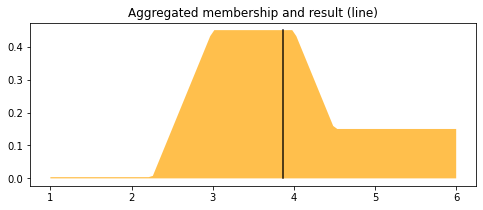

In [7]:
# Define fuzzy control system
rules = [rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9]
sim = fuzzySystem([temp_T1,temp_T2],n_safety,rules)

# Compute for given inputs
inputs = np.array([
    370.0, # T1
    580.0, # T2
    ])
n_safety_value, aggregate, n_safety_activation = sim.compute(inputs, normalize=True)

# Visualize this
import matplotlib.pyplot as plt
fig, ax0 = plt.subplots(figsize=(8, 3))

n_0 = np.zeros_like(n_safety.universe)

ax0.fill_between(n_safety.universe, n_0, aggregate, facecolor='Orange', alpha=0.7)
ax0.plot([n_safety_value, n_safety_value], [0, n_safety_activation], 'k', linewidth=1.5, alpha=0.9)
ax0.set_title('Aggregated membership and result (line)')

plt.show()

### Capability calculation

We now compute the capability of the TRS to handle the load case given by $T_1 = 370^o{\text{C}}$ and $T_2 = 580^o{\text{C}}$. This is given by the condition that the probability of the safety factor $n_\text{safety}$ being larger than a threshold (given by $t = 2.8$ for example) must be greater than 90%

$$
\mathbb{P}\left[n_\text{safety} \ge t\right] \ge 0.9
$$

The probability can be calculated from the above membership function by integrating the area under the curve from 2.8 to 6.0

$$
\mathbb{P}\left[n_\text{safety} \ge t\right] = \int_{t}^\infty a(n_\text{safety})dn_\text{safety}
$$

which can be estimated using the trapezoidal rule. In python we use ``np.trapz`` to do this

area = 0.817215


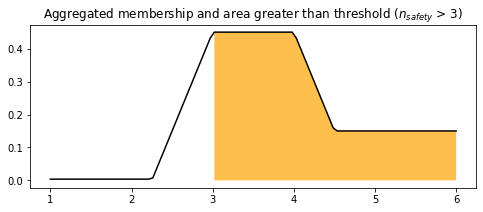

In [18]:
# Define threshold safety factor
threshold = 3.0 # threshold in universe

# Compute capability of the design
feasible_condition = n_safety.universe > threshold
area = np.trapz(aggregate[feasible_condition], x=n_safety.universe[feasible_condition])

print("area = %f" %area)

# Visualize this
fig, ax0 = plt.subplots(figsize=(8, 3))

n_0 = np.zeros_like(n_safety.universe)

ax0.plot(n_safety.universe, aggregate, 'k')
ax0.fill_between(n_safety.universe[feasible_condition], n_0[feasible_condition], aggregate[feasible_condition], facecolor='Orange', alpha=0.7)
ax0.set_title('Aggregated membership and area greater than threshold ($n_{safety}$ > 3)')

plt.show()

According to this calculation, the load case $T_1 = 370^o{\text{C}}$ and $T_2 = 580^o{\text{C}}$ is not part of the design's capability.

## Fuzzy inference on multiple combinations of loads (2D parameter space)

Next we infer the value of ``n_safety`` for different combinations of ``T1`` and ``T2`` by sweeping over them. We first create a 2D full factorial grid of the variables

In [ ]:
from dmLib import Design

# Simulate at higher resolution the control space in 2D
n_levels = 20
inputs = Design(lb[:2],ub[:2],n_levels,"fullfact").unscale()


Next, we retrieve the crisp values ``z`` for each of the samples in ``inputs``

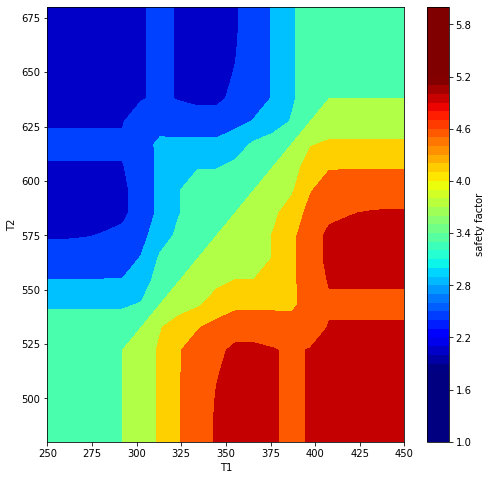

In [ ]:
# Loop through the system to collect the control surface
z,a,_ = sim.compute(inputs)

# Reshape the outputs for contour plotting
x = inputs[:,0].reshape((n_levels,n_levels))
y = inputs[:,1].reshape((n_levels,n_levels))
z = z.reshape((n_levels,n_levels))

# Plot the result in 2D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()

surf = ax.contourf(x, y, z, cmap=plt.cm.jet,)
ax.set_xlabel('T1')
ax.set_ylabel('T2')

cbar = plt.cm.ScalarMappable(cmap=plt.cm.jet)
cbar.set_array(z)

boundaries = np.linspace(1, 6, 51)
cbar_h = fig.colorbar(cbar, boundaries=boundaries)
cbar_h.set_label('safety factor', rotation=90, labelpad=3)

plt.show()

## Capability calculation

We now compute the capability of the TRS (the combination of loads that is able to satisfy reliably). This is given by the condition that the probability of the safety factor $n_\text{safety}$ being larger than a threshold $t$ must be greater than 90%

$$
\mathbb{P}\left[n_\text{safety} \ge t\right] \ge 0.9
$$